In [1]:
import numpy as np
import xobjects as xo
import xtrack as xt
import xpart as xp
import json
import pandas as pd
from cpymad.madx import Madx
#from matplotlib import pyplot as plt
import NAFFlib
from math import modf
#from scipy.constants import physical_constants
from matplotlib import pyplot as plt
from scipy.stats import linregress

In [97]:
#--------input and context---------

i_mo = -350
p0c = 7000e9
normal_emitt_x = 3e-6 #m*rad
normal_emitt_y = 3e-6 #m*rad
N_particles = 11 
N=1000
n_turns= 1

ctx_cpu = xo.ContextCpu()

#--------Opening the file---------

if False:
    mad = Madx()
    mad.option(echo=False)
    mad.call('andrea.madx')
    mad.use(sequence="lhcb1")
    line = xt.Line.from_madx_sequence(mad.sequence['lhcb1'],
                                  deferred_expressions=True
                                  )
    with open('line.json', 'w') as fid:
        json.dump(line.to_dict(), fid, cls=xo.JEncoder)

else:
    with open('line.json', 'r') as fid:
        loaded_dct = json.load(fid)
    line = xt.Line.from_dict(loaded_dct)

#-----preparing for tracking------

particle_0 = xp.Particles(_context=ctx_cpu, p0c=p0c)
line.vars['i_mo'] = i_mo
line.vars['cmrs.b1_sq']=0.5*line.vars['cmrs.b1_sq']


tracker_normal = xt.Tracker(_context=ctx_cpu, line=line)
tw_normal = tracker_normal.twiss(particle_0)


betx_at_ip3 = tw_normal['betx'][0]
bety_at_ip3 = tw_normal['bety'][0]

#----defining the sigma in both directions---------

sigma_x = np.sqrt(betx_at_ip3*normal_emitt_x/(particle_0.gamma0*particle_0.beta0))
sigma_y = np.sqrt(bety_at_ip3*normal_emitt_y/(particle_0.gamma0*particle_0.beta0))

#-----closed orbit particle-----

p0_normal = tw_normal['particle_on_co']

#-----choose one of the two to have a particle with x or y displacement----------------

#particles_normal = xp.build_particles(_context=ctx_cpu,particle_ref=p0_normal,
#                                      x=[mysigma*sigma_x[0] for mysigma in np.linspace(0.2,2.2,N_particles)])
particles_normal = xp.build_particles(_context=ctx_cpu,particle_ref=p0_normal,
                                      y=[mysigma*sigma_y[0] for mysigma in np.linspace(0.2,2.2,N_particles)])

#-----tracking------------------

my_result = {}
for ii in ['x','px','y','py','zeta','delta']:
    my_result[ii] = []


for ii in range(N):
    tracker_normal.track(particles_normal, num_turns=n_turns,turn_by_turn_monitor=False)
    for jj in ['x','px','y','py','zeta','delta']:
        my_result[jj].append(getattr(particles_normal,jj).copy())       
        #my_result[jj].append(getattr(particles_normal,jj).copy())

for jj in ['x','px','y','py','zeta','delta']:
        my_result[jj] = np.array(my_result[jj])
        #my_result[jj] = np.array(my_result[jj])


#-------tunes-------

qx_normal = []
qy_normal = []

for ii in range(N_particles):
    
    qx_normal.append(NAFFlib.get_tune(my_result['x'][:,ii]))
    qy_normal.append(NAFFlib.get_tune(my_result['y'][:,ii]))

x0 = np.array([mysigma*sigma_x[0] for mysigma in np.linspace(0.2,2.2,N_particles)]) 
y0 = np.array([mysigma*sigma_y[0] for mysigma in np.linspace(0.2,2.2,N_particles)]) 

generating ./52c70911c7f8465eaba157e4ad51b523.c
the current directory is '/home/afornara/studies/git_postprocessing'
running build_ext
building '52c70911c7f8465eaba157e4ad51b523' extension
gcc -pthread -B /home/afornara/py/2022_03_04/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/afornara/py/2022_03_04/miniconda/include -I/home/afornara/py/2022_03_04/miniconda/include -fPIC -O2 -isystem /home/afornara/py/2022_03_04/miniconda/include -fPIC -I/home/afornara/py/2022_03_04/miniconda/include/python3.9 -c 52c70911c7f8465eaba157e4ad51b523.c -o ./52c70911c7f8465eaba157e4ad51b523.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/afornara/py/2022_03_04/miniconda/compiler_compat -shared -Wl,-rpath,/home/afornara/py/2022_03_04/miniconda/lib -Wl,-rpath-link,/home/afornara/py/2022_03_04/miniconda/lib -L/home/afornara/py/2022_03_04/miniconda/lib -L/home/afornara/py/2022_03_04/miniconda/lib -Wl,-rpath,/home/afornara/py/2022_03_04/minicon

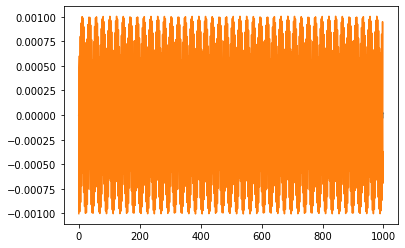

In [92]:
#print((my_result['y'][:,ii]))

plt.plot(my_result['x'][:,5])
plt.plot(my_result['y'][:,5])

In [98]:
print(qy_normal)

[0.31793628280901876, 0.31789544263884995, 0.31782737948179146, 0.31773208153055, 0.31760956633414983, 0.31745986045698077, 0.3172830126992925, 0.31707915448527413, 0.31684875976017324, 0.31659246898979365, 0.3163082802312394]


In [99]:
qx_oct = [0.3130392367767762, 0.3130072668477651, 0.31295406648644775, 0.3128796612559198, 0.31278408167925603, 0.31266730805307313, 0.3125293308986112, 0.31237011602780185, 0.31218961238811094, 0.3119877663612319, 0.3117645252777741]
qx_no_oct = [0.31305066000753434, 0.3130529022749124, 0.31305663178354837, 0.3130618428745969, 0.3130685303763514, 0.3130766895984234, 0.3130863204690079, 0.31309740543336223, 0.31310996044315864, 0.3131239669885427, 0.31313943088427765]
qy_oct = [0.31793628278655894, 0.31789544259934155, 0.31782737942221667, 0.3177320814777581, 0.31760956634590476, 0.31745986045967894, 0.3172830122856016, 0.31707915400236925, 0.3168487597641903, 0.3165924554773461, 0.3163082566310991]
qy_no_oct = [0.3179506881505412, 0.3179530622785385, 0.3179570188226742, 0.3179625562382878, 0.31796968217004856, 0.3179783816723068, 0.31798866902724254, 0.31800053237955056, 0.3180139789749532, 0.318029008611634, 0.31804562082779614]

m =  -220630.16148327294 q =  0.31304988306306725
-197165.79593111496


1000

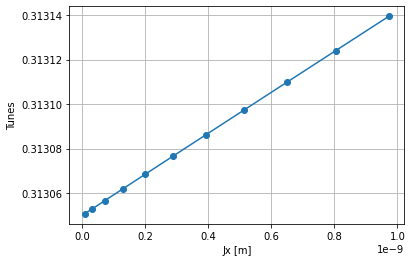

In [105]:
#Monitor detuning study, x direction
x0 = np.array([mysigma*sigma_x[0] for mysigma in np.linspace(0.2,2.2,N_particles)])

jx = np.zeros(N_particles)


for ii in range(N_particles):
    jx[ii] = x0[ii]*x0[ii]/(2*betx_at_ip3)



plt.plot(jx,qx_no_oct,'-o');
#plt.plot(jx,qx_oct,'-o')
plt.grid()
#plt.ylim(-0.002,0.005)
#print(j[0],dq[0],j[8],dq[8])
plt.ylabel('Tunes')
plt.xlabel('Jx [m]')


slope, intercept, r_value, p_value, std_err = linregress([jx[0],jx[2]],[qx_oct[0],qx_oct[2]])
print('m = ',slope/6,'q = ',intercept)
m = ((qx_oct[2]-qx_oct[0])+(140786.19331294773*(jy[2]-jy[0])))/(jx[2]-jx[0])
print(m/6)

#print(tracker_monitor.record_last_track.x[0])
#len(tracker_monitor.record_last_track.x[0])
len(my_result['x'][:,ii])

-258645.35566926698
m =  -282109.72122142493 q =  0.31794989570710175


1000

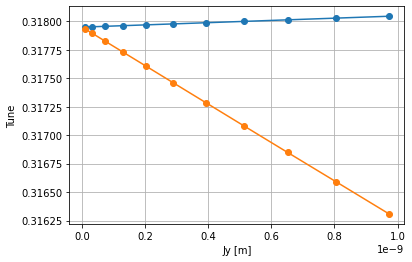

In [104]:
#Monitor detuning study, x direction
x0 = np.array([mysigma*sigma_x[0] for mysigma in np.linspace(0.2,2.2,N_particles)])

jy = np.zeros(N_particles)


for ii in range(N_particles):
    jy[ii] = y0[ii]*y0[ii]/(2*bety_at_ip3)



plt.plot(jy,qy_no_oct,'-o');
plt.plot(jy,qy_oct,'-o')
plt.grid()
#plt.ylim(-0.002,0.005)
#print(j[0],dq[0],j[8],dq[8])
plt.ylabel('Tune')
plt.xlabel('Jy [m]')
m = ((qy_oct[2]-qy_oct[0])+(140786.19331294773*(jx[2]-jx[0])))/(jy[2]-jy[0])
print(m/6)

slope, intercept, r_value, p_value, std_err = linregress([jy[0],jy[2]],[qy_oct[0],qy_oct[2]])
#slope = slope/6+140786.19331294773*jx[2]
print('m = ',slope/6,'q = ',intercept)

#print(tracker_monitor.record_last_track.x[0])
#len(tracker_monitor.record_last_track.x[0])
len(my_result['x'][:,ii])

In [102]:
tracker1 = xt.Tracker(_context=ctx_cpu, line=line)
tw = tracker1.twiss(particle_0)

generating ./1fbd3e94e19c4164a39a1e1389257c90.c
the current directory is '/home/afornara/studies/git_postprocessing'
running build_ext
building '1fbd3e94e19c4164a39a1e1389257c90' extension
gcc -pthread -B /home/afornara/py/2022_03_04/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/afornara/py/2022_03_04/miniconda/include -I/home/afornara/py/2022_03_04/miniconda/include -fPIC -O2 -isystem /home/afornara/py/2022_03_04/miniconda/include -fPIC -I/home/afornara/py/2022_03_04/miniconda/include/python3.9 -c 1fbd3e94e19c4164a39a1e1389257c90.c -o ./1fbd3e94e19c4164a39a1e1389257c90.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/afornara/py/2022_03_04/miniconda/compiler_compat -shared -Wl,-rpath,/home/afornara/py/2022_03_04/miniconda/lib -Wl,-rpath-link,/home/afornara/py/2022_03_04/miniconda/lib -L/home/afornara/py/2022_03_04/miniconda/lib -L/home/afornara/py/2022_03_04/miniconda/lib -Wl,-rpath,/home/afornara/py/2022_03_04/minicon

In [103]:
with open('line.json', 'r') as fid:
    loaded_dct = json.load(fid)
line = xt.Line.from_dict(loaded_dct)
line.vars['i_mo'] = i_mo
sum_nl_x = 0.0
sum_nl_y = 0.0
sum_nl_xy = 0.0
ii = 0
for elem in line.element_dict :
    if isinstance(line.element_dict[elem],xt.beam_elements.elements.Multipole): 
        if(line.element_dict[elem].order==3):
                #print(elem)
                #print(line.element_dict[elem].length)
                #print(line.element_dict[elem].knl)
                sum_nl_x+=line.element_dict[elem].knl[3]*tw['betx'][ii]*tw['betx'][ii]
                sum_nl_y+=line.element_dict[elem].knl[3]*tw['bety'][ii]*tw['bety'][ii]
                sum_nl_xy+=line.element_dict[elem].knl[3]*tw['betx'][ii]*tw['bety'][ii]
        if(line.element_dict[elem].order==2):
                line.element_dict[elem].knl[2]=0
                #print(line.element_dict[elem].knl)
    ii+=1

m_x = (sum_nl_x)/(16*np.pi)
m_y = (sum_nl_y)/(16*np.pi)
m_xy = (-sum_nl_xy)/(8*np.pi)

print(m_x,m_y,m_xy)

-227341.61128685813 -225003.01024783653 140786.19331294773


- ```normal_emitt_x = 3e-6 #m*rad``` -> m
- ```sigma_x = np.sqrt(betx_at_ip3*normal_emitt_x/(particle_0.gamma0*particle_0.beta0))``` -> sqrt(m*m/no_dimension)-> m 
- ```jx[ii] = x0[ii]*x0[ii]/(2*betx_at_ip3)``` -> m*m/m -> m
- ```sum_nl_x+=line.element_dict[elem].knl[3]*tw['betx'][ii]*tw['betx'][ii]```-> $m^{-3}$(?)*$m^{2}$-> $m^{-1}$
Total dqx (no dimension) = ang_coeff ($m^{-1}$) * jx ( m ) -> no dimension = no dimension !

In [114]:
#--------input and context---------

i_mo = 0
p0c = 7000e9
normal_emitt_x = 3e-6 #m*rad
normal_emitt_y = 3e-6 #m*rad
N_particles = 11 
N=1000
n_turns= 1

ctx_cpu = xo.ContextCpu()

#-----preparing for tracking------

particle_0 = xp.Particles(_context=ctx_cpu, p0c=p0c)
line.vars['i_mo'] = i_mo
#line.vars['cmrs.b1_sq']=0.5*line.vars['cmrs.b1_sq']


tracker_normal = xt.Tracker(_context=ctx_cpu, line=line)
tw_normal = tracker_normal.twiss(particle_0)


betx_at_ip3 = tw_normal['betx'][0]
bety_at_ip3 = tw_normal['bety'][0]

#----defining the sigma in both directions---------

sigma_x = np.sqrt(betx_at_ip3*normal_emitt_x/(particle_0.gamma0*particle_0.beta0))
sigma_y = np.sqrt(bety_at_ip3*normal_emitt_y/(particle_0.gamma0*particle_0.beta0))

#-----closed orbit particle-----

p0_normal = tw_normal['particle_on_co']

#-----choose one of the two to have a particle with x or y displacement----------------

particles_normal = xp.build_particles(_context=ctx_cpu,particle_ref=p0_normal,
                                      x=[mysigma*sigma_x[0] for mysigma in np.linspace(0.2,2.2,N_particles)])
#particles_normal = xp.build_particles(_context=ctx_cpu,particle_ref=p0_normal,
#y=[mysigma*sigma_y[0] for mysigma in np.linspace(0.2,2.2,N_particles)])

#-----tracking------------------

my_result = {}
for ii in ['x','px','y','py','zeta','delta']:
    my_result[ii] = []


for ii in range(N):
    tracker_normal.track(particles_normal, num_turns=n_turns,turn_by_turn_monitor=False)
    for jj in ['x','px','y','py','zeta','delta']:
        my_result[jj].append(getattr(particles_normal,jj).copy())       
        #my_result[jj].append(getattr(particles_normal,jj).copy())

for jj in ['x','px','y','py','zeta','delta']:
        my_result[jj] = np.array(my_result[jj])
        #my_result[jj] = np.array(my_result[jj])


#-------tunes-------

qx_normal = []
qy_normal = []

for ii in range(N_particles):
    
    qx_normal.append(NAFFlib.get_tune(my_result['x'][:,ii]))
    qy_normal.append(NAFFlib.get_tune(my_result['y'][:,ii]))

x0 = np.array([mysigma*sigma_x[0] for mysigma in np.linspace(0.2,2.2,N_particles)]) 
y0 = np.array([mysigma*sigma_y[0] for mysigma in np.linspace(0.2,2.2,N_particles)]) 

generating ./b22bf00287044556adc68e08dc373456.c
the current directory is '/home/afornara/studies/git_postprocessing'
running build_ext
building 'b22bf00287044556adc68e08dc373456' extension
gcc -pthread -B /home/afornara/py/2022_03_04/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/afornara/py/2022_03_04/miniconda/include -I/home/afornara/py/2022_03_04/miniconda/include -fPIC -O2 -isystem /home/afornara/py/2022_03_04/miniconda/include -fPIC -I/home/afornara/py/2022_03_04/miniconda/include/python3.9 -c b22bf00287044556adc68e08dc373456.c -o ./b22bf00287044556adc68e08dc373456.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/afornara/py/2022_03_04/miniconda/compiler_compat -shared -Wl,-rpath,/home/afornara/py/2022_03_04/miniconda/lib -Wl,-rpath-link,/home/afornara/py/2022_03_04/miniconda/lib -L/home/afornara/py/2022_03_04/miniconda/lib -L/home/afornara/py/2022_03_04/miniconda/lib -Wl,-rpath,/home/afornara/py/2022_03_04/minicon

In [115]:
print(qx_normal)

[0.3129999811552932, 0.3129999827272727, 0.31299998534012013, 0.3129999889938052, 0.31299999368836384, 0.31299999942380374, 0.313000006200069, 0.3130000140172004, 0.31300002287519935, 0.31300003277404326, 0.31300004371376666]


In [116]:
qx_oct = [0.31298915672551, 0.31295665075936835, 0.3129023743775689, 0.31282617538611907, 0.3127278737598104, 0.31260727758286205, 0.3124642016259394, 0.3122984838368747, 0.3121099888219403, 0.3118985963358075, 0.3116642582190187]
qx_no_oct = [0.3129999811552932, 0.3129999827272727, 0.31299998534012013, 0.3129999889938052, 0.31299999368836384, 0.31299999942380374, 0.313000006200069, 0.3130000140172004, 0.31300002287519935, 0.31300003277404326, 0.31300004371376666]
qy_oct = [0.3179864018161214, 0.31794560413324036, 0.31787778537308836, 0.31778325761735776, 0.3176625376797424, 0.3175165129912427, 0.3173465326847202, 0.31715436878480313, 0.3169429411126197, 0.31671955447878025, 0.3164924105749956]
qy_no_oct = [0.31800002580777964, 0.31800002774937036, 0.3180000309853371, 0.31800003551568573, 0.318000041340406, 0.3180000484595221, 0.31800005687302935, 0.31800006658090413, 0.3180000775831715, 0.31800008987983297, 0.3180001034708594]

m =  -204822.67979319234 q =  0.3129990402376886
-202149.9212013185


1000

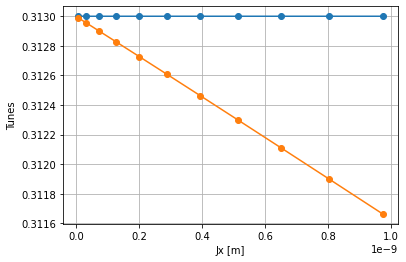

In [126]:
#Monitor detuning study, x direction
x0 = np.array([mysigma*sigma_x[0] for mysigma in np.linspace(0.2,2.2,N_particles)])

jx = np.zeros(N_particles)


for ii in range(N_particles):
    jx[ii] = x0[ii]*x0[ii]/(2*betx_at_ip3)



plt.plot(jx,qx_no_oct,'-o');
plt.plot(jx,qx_oct,'-o')
plt.grid()
#plt.ylim(-0.002,0.005)
#print(j[0],dq[0],j[8],dq[8])
plt.ylabel('Tunes')
plt.xlabel('Jx [m]')


slope, intercept, r_value, p_value, std_err = linregress([jx[0],jx[9]],[qx_oct[0],qx_oct[9]+m_xy*(jy[9]-jy[0])])
print('m = ',slope/6,'q = ',intercept)
m = ((qx_oct[4]-qx_oct[0])+(m_xy*(jy[4]-jy[0])))/(jx[4]-jx[0])
print(m/6)

# qx_oct[4]-qx_oct[0] =  mx/6(jx[4]-jx[0])/2 + mxy(jy[4]-jy[0])/2
# (2deltaq-mxy deltajy)/deltajx = mx/6

#mx = 2(qx_oct[4]-qx_oct[0])-

#2deltaqx=mxdeltajx+mxydeltajy

len(my_result['x'][:,ii])

-256187.91081631472
m =  -241724.8328416569 q =  0.3179980660045387


1000

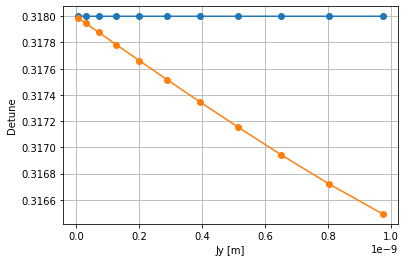

In [129]:
#Monitor detuning study, y direction
jy = np.zeros(N_particles)


for ii in range(N_particles):
    jy[ii] = y0[ii]*y0[ii]/(2*bety_at_ip3)



plt.plot(jy,qy_no_oct,'-o');
plt.plot(jy,qy_oct,'-o')
plt.grid()
plt.ylabel('Detune')
plt.xlabel('Jy [m]')
m = ((qy_oct[4]-qy_oct[0])+(m_xy*(jx[4]-jx[0])))/(jy[4]-jy[0])
print(m/6)

slope, intercept, r_value, p_value, std_err = linregress([jy[0],jy[9]],[qy_oct[0],qy_oct[9]+m_xy*(jx[9]-jx[0])])
#slope = slope/6+140786.19331294773*jx[2]
print('m = ',slope/6,'q = ',intercept)
#print(tracker_monitor.record_last_track.x[0])
#len(tracker_monitor.record_last_track.x[0])
len(my_result['x'][:,ii])